# Exploring the FuseTS Toolbox: Fusing Optical and SAR Data for Phenology Analysis

Welcome to the showcase of the FuseTS library, an integral part of the AI4FOOD project, presented at the FOSS4G conference. In this Jupyter notebook, we will demonstrate how the FuseTS library enables users to effectively fuse optical and SAR data, harnessing the power of fused data sets combined time series analytics for extracting valuable phenology information.

Throughout this notebook, we will compare the results obtained from a raw dataset with those obtained from the fused dataset, illustrating the significant improvements in extracting phenology information. By integrating optical data, which provides detailed spectral information, with SAR data, which excels in all-weather and day-night imaging, the FuseTS library empowers users to unlock deeper insights into vegetation dynamics and crop monitoring.

**Prerequisites**

- In this notebook we are using openEO to fetch the time series data for the meadow. You can register for a free trial account on the [openEO Platform](https://openeo.cloud/#plans) website.


Lets start with importing the different libraries that we need within this notebook.


In [1]:
import os
import sys

# Add local version of FuseTS
module_path = os.path.abspath(os.path.join("../../src"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import openeo
import xarray
from ipyleaflet import GeoJSON, Map

from fusets.analytics import phenology

warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# PART 1: Downloading the raw S2 NDVI time series

We start by downloading the raw S2 NDVI data that we need for our analysis. Retrieving time series data can be done through various methods, and one such method is using openEO. [OpenEO](https://openeo.org/) is an API that provides access to a variety of Earth Observation (EO) data and processing services in a standardized and easy-to-use way. By leveraging the power of openEO, we can easily retrieve the time series data for the meadow and use it to analyze the patterns and trends.

More information on the usage of openEO's Python client can be found on [GitHub](https://github.com/Open-EO/openeo-python-client).

The first step is to connect to an openEO compatible backend.


In [2]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()


OIDC token response did not contain refresh token.


Authenticated using refresh token.


Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.


In [3]:
year = 2022
spat_ext = {
    "coordinates": [
        [
            [5.179169745059369, 51.24984286550534],
            [5.170016107999743, 51.25052999567865],
            [5.171081610725707, 51.24861004739975],
            [5.178604705735125, 51.246720335821465],
            [5.179169745059369, 51.24984286550534],
        ]
    ],
    "type": "Polygon",
}
temp_ext = [f"{year}-01-01", f"{year}-12-30"]


Plot the area to see what we're working with.


In [4]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 15

m = Map(center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m


Map(center=[51.24910922198211, 5.175608382915863], controls=(ZoomControl(options=['position', 'zoom_in_text', …

We will create an openEO process to calculate the NDVI time series for our area of interest. We'll begin by using the `SENTINEL2_L2A_SENTINELHUB` collection, and apply a cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.


In [5]:
s2 = connection.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["B04", "B08", "SCL"],
)
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
s2 = s2.mask_polygon(spat_ext)
ndvi_cube = s2.ndvi(red="B04", nir="B08", target_band="NDVI")


Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook.


In [6]:
ndvi_output_file = "./raw_s2_ndvi_field.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# ndvi_job = ndvi_cube.execute_batch(
#     ndvi_output_file, title=f"FOSS4G - FUSETS - Phenology - Raw NDVI", out_format="netCDF"
# )


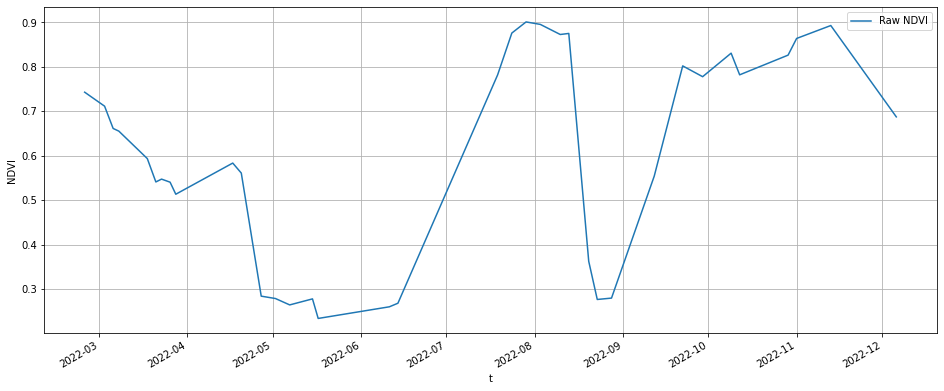

In [7]:
raw_ndvi_ds = xarray.load_dataset(ndvi_output_file)
raw_ndvi = raw_ndvi_ds.NDVI.rename({"t": "time"})

fig, ax = plt.subplots(figsize=(16, 6))

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, label='Raw NDVI')
ax.legend()
ax.grid()


## PART 2: Creating the fused data set

In the following section, we will leverage the capabilities of the toolbox to generate a fused dataset using CropSAR. The CropSAR service is specifically designed to enhance crop monitoring and analysis by integrating Sentinel-2 optical observations with Sentinel-1 radar data. This fusion process empowers users to monitor agricultural fields regardless of weather conditions or daylight availability, making it an invaluable tool for comprehensive crop assessment.

To execute the CropSAR service and obtain the fused dataset, we will once again utilize openEO. By leveraging openEO, we can easily harness the power of CropSAR and efficiently download the fused dataset, enabling further analysis and extraction of valuable phenology information in the next part.


In [8]:
service = "CropSAR_px"
namespace = "vito"


In [9]:
cropsar_cube = connection.datacube_from_process(
    service,
    namespace=namespace,
    geometry=spat_ext,
    startdate=temp_ext[0],
    enddate=temp_ext[1],
    version=2,
    model_path="tmp/model/cnn_transformer/",
    path_extras=["tmp/env/env/"],
)


In [10]:
cropsar_output_file = "./cropsar_ndvi.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# cropsar_job = cropsar_cube.execute_batch(
#     cropsar_output_file,
#     title="FOSS4G - FUSETS - Phenology - CropSAR",
#     out_format="netcdf",
#     job_options={
#         "executor-cores": "8",
#         "task-cpus": "8",
#         "executor-memoryOverhead": "2g",
#         "udf-dependency-archives": [
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/20230504T175919_cnn_transformer.zip#tmp/model/cnn_transformer",
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/env.tar.gz#tmp/env",
#         ],
#     },
# )


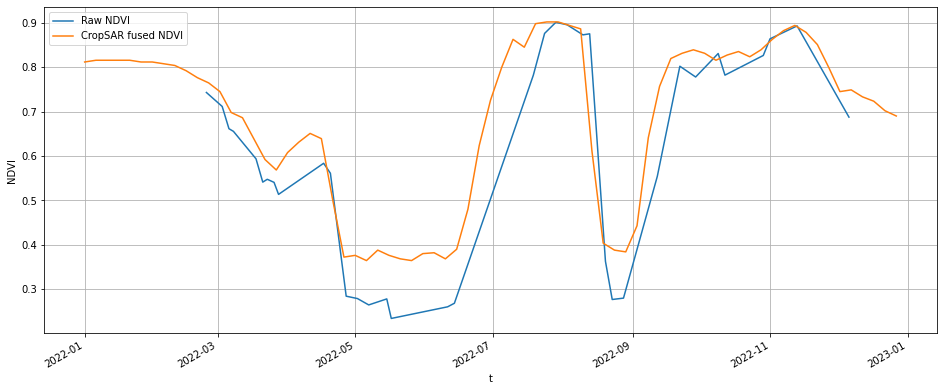

In [11]:
cropsar_ds = xarray.load_dataset(cropsar_output_file)
cropsar = cropsar_ds.NDVI.rename({"t": "time"}) / 255  # from uint8 to float21

fig, ax = plt.subplots(figsize=(16, 6))

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, label='Raw NDVI')
cropsar.median(dim=["x", "y"]).plot(ax=ax, label='CropSAR fused NDVI')
ax.legend()
ax.grid()

## PART 3: Phenology calculation

In this final step, we will utilize both the raw and CropSAR-based time series data to extract valuable phenology information. To accomplish this, we will employ the `phenology` service. By leveraging this service, we can extract a range of essential metrics, including the start, peak, and end of the growing season.

The calculation is based on the [phenolopy]() python package.

![phenolopy](https://github.com/lewistrotter/Phenolopy/raw/main/documentation/images/pheno_explain.png?raw=true)


In [12]:
# run phenology on raw NDVI
raw_phenology = phenology(raw_ndvi)

# run phenology on fused NDVI
cropsar_phenology = phenology(cropsar)


Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

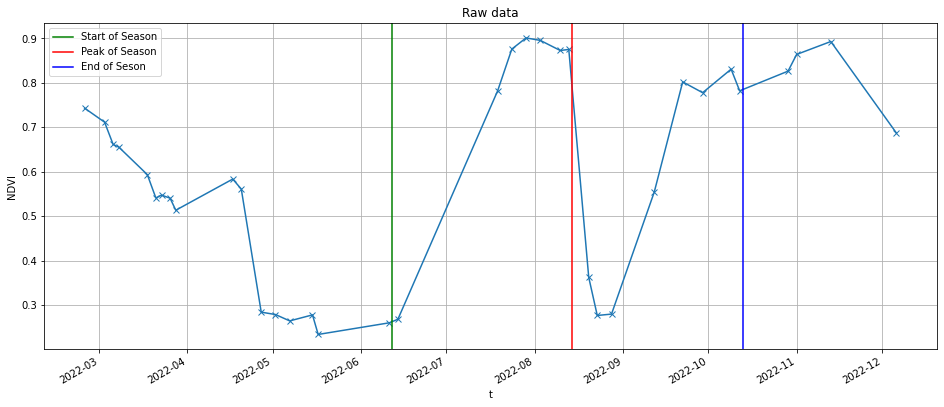

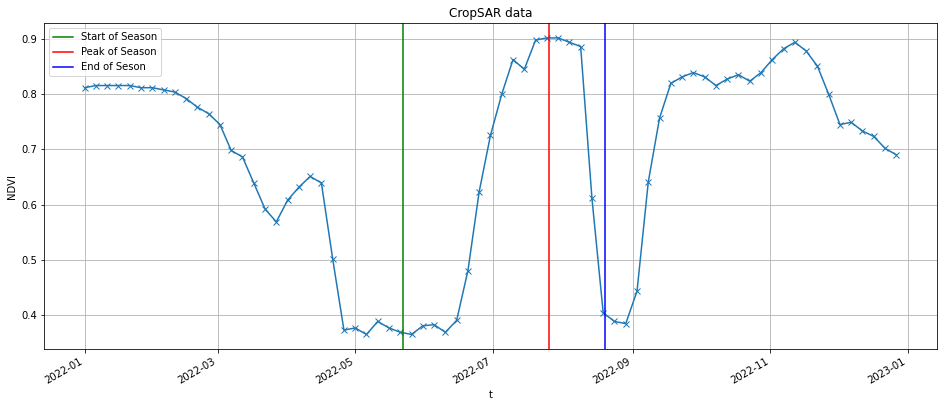

In [13]:
# utility function to plot extracted phenology metrics
def showPlot(title, data, phenology):
    average = data.median(dim=["x", "y"])

    sos = phenology.sos_times.median(dim=["x", "y"]).values.take(0)
    pos = phenology.pos_times.median(dim=["x", "y"]).values.take(0)
    eos = phenology.eos_times.median(dim=["x", "y"]).values.take(0)

    sos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=sos)
    pos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=pos)
    eos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=eos)

    _, ax = plt.subplots(figsize=(16, 6))

    average.plot.line("C0x-")
    ax.axvline(x=sos_date, color="g", label="Start of Season")
    ax.axvline(x=pos_date, color="r", label="Peak of Season")
    ax.axvline(x=eos_date, color="b", label="End of Seson")

    ax.set_ylabel("NDVI")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()


showPlot("Raw data", raw_ndvi, raw_phenology)
showPlot("CropSAR data", cropsar, cropsar_phenology)
